<a href="https://colab.research.google.com/github/AnitaKirkovska/Bio_Project_Results/blob/master/model_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Upload & Unzip the Data

In [0]:
!rm -r Data
!rm Data.zip
!rm -r sample_data
!ls
from google.colab import files
uploaded = files.upload()
!unzip Data.zip
!ls Data/

rm: cannot remove 'sample_data': No such file or directory


Saving Data.zip to Data.zip
Archive:  Data.zip
   creating: Data/
  inflating: Data/time3_transposed_format.csv  
  inflating: Data/time2_transposed_format.csv  
  inflating: Data/time1_transposed_format_train - time1_transposed_format.csv  


#Define the Data Generator

In [0]:
import glob
import os
import csv
import random
import numpy as np
import tensorflow.keras as keras

class data_gen(keras.utils.Sequence):
	def get_data(self):
		files = glob.glob("Data/*")
		raw_data = []
		for file in files:
			with open(file, 'r') as f:
				f_csv = csv.reader(f)
				raw_datum = [row for row in f_csv]
				raw_data += raw_datum[1:]

		# {'control' : [ctrl_plant_name1, ctrl_plant_name2, ...]}
		#	'nitrogen' : [nitrogen_plant_name1, nitrogen_plant_name2, ...]}
		plants = {'control': set(), 'nitrogen': set()}
		# {plant_name : [hyperspec1, hyperspec2, hyperspec3]}
		specs = {}

		# Returns the class of the plant, and the formatted plant name
		def get_plant(filepath):
			filename = os.path.basename(filepath)
			split = filename.split('_')
			plant_name = split[0] + '_' + split[1] + '_' + split[2] + '_' + split[3] + '_' + split[4]
			plant_name = plant_name.upper()

			if (split[0] == 'c' or split[0] == 'C'):
				category = 'control'
			elif (split[0] == 'n' or split[0] == 'N'):
				category = 'nitrogen'
			else:
				print('Unknown Class:', filename)

			return [category, plant_name]

		for datum in raw_data:
			# Associate the plant_name with the class
			category, plant_name = get_plant(datum[0])
			plants[category].add(plant_name)
			# Associate the plant_name with its hyperspecs
			spec = np.array(datum[1:]).astype(np.float32)			
			plant_specs = specs.get(plant_name, [])
			plant_specs.append(spec)
			specs[plant_name] = plant_specs

		return plants, specs

	def __init__(self, batch_size, dim):
		self.batch_size = int(batch_size/2*2)
		self.dim = dim
		self.plants, self.specs = self.get_data()

		control_train_idxs = np.random.choice(range(len(self.plants['control'])), 27, replace=False)
		nitrogen_train_idxs = np.random.choice(range(len(self.plants['nitrogen'])), 27, replace=False)
		
		self.plants_train = {'control' : set(), 'nitrogen' : set()}
		self.plants_test = {'control' : set(), 'nitrogen' : set()}
		
		for i, plant_name in enumerate(self.plants['control']):
				if i in control_train_idxs:			
					self.plants_train['control'].add(plant_name)
				else:
					self.plants_test['control'].add(plant_name) 

		for i, plant_name in enumerate(self.plants['nitrogen']):
				if i in nitrogen_train_idxs:			
					self.plants_train['nitrogen'].add(plant_name)
				else:
					self.plants_test['nitrogen'].add(plant_name) 

		self.epoch_data = {}
		self.on_epoch_end()

	def __len__(self):
		num_plants = min(len(self.plants['control']), len(self.plants['nitrogen'])) * 2
		return int(np.floor(num_plants / self.batch_size))

	def on_epoch_end(self):
		self.control_plants = list(self.plants_train['control'])
		random.shuffle(self.control_plants)
		self.nitrogen_plants = list(self.plants_train['nitrogen'])
		random.shuffle(self.nitrogen_plants)

	def __getitem__(self, index):
		start = int(index * self.batch_size / 2)
		end = int((index + 1) * self.batch_size / 2)
		control_plants = self.control_plants[start:end]
		nitrogen_plants = self.nitrogen_plants[start:end]

		num_plants = len(control_plants) + len(nitrogen_plants)

		X = np.empty((num_plants, self.dim, 1))
		y = np.empty((num_plants, 1))

		# Get the control data samples
		for i, plant_name in enumerate(control_plants):
			plant_specs = self.specs[plant_name]
			X[i] = random.choice(plant_specs).reshape(-1, 1)
			y[i] = 0
		
		# Get the nitrogen data samples
		for j, plant_name in enumerate(nitrogen_plants):
			plant_specs = self.specs[plant_name]
			X[i+j+1] = random.choice(plant_specs).reshape(-1, 1)
			y[i+j+1] = 1

		return X, y

	def test_batch(self):
			control_plants = list(self.plants_test['control'])
			nitrogen_plants = list(self.plants_test['nitrogen'])

			num_plants = len(control_plants) + len(nitrogen_plants)

			X = np.empty((num_plants, self.dim, 1))
			y = np.empty((num_plants, 1))

			# Get the control data samples
			for i, plant_name in enumerate(control_plants):
				plant_specs = self.specs[plant_name]
				X[i] = random.choice(plant_specs).reshape(-1, 1)
				y[i] = 0
			
			# Get the nitrogen data samples
			for j, plant_name in enumerate(nitrogen_plants):
				plant_specs = self.specs[plant_name]
				X[i+j+1] = random.choice(plant_specs).reshape(-1, 1)
				y[i+j+1] = 1

			return X, y


#Make the Model

In [0]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, Conv1D, Conv2D, BatchNormalization, MaxPool1D, Concatenate
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import BatchNormalization

data_len = 2348
# Build the hyperspec 1DCNN
hyperspec_input = Input(shape=(data_len, 1))
hyperspec_base = Conv1D(filters=20, kernel_size=24, strides=1, padding='valid', activation='tanh')(hyperspec_input)
hyperspec_base = BatchNormalization()(hyperspec_base)
hyperspec_base = MaxPool1D(pool_size=5, strides=None)(hyperspec_base)
hyperspec_base = Flatten()(hyperspec_base)

z = Dense(100, activation='tanh')(hyperspec_base)
z = Dense(1, activation = 'sigmoid')(z)

# Create the full model
model = Model(hyperspec_input, z)
#plot_model(model, show_shapes=True, show_layer_names=True)

In [0]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 2348, 1)]         0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 2325, 20)          500       
_________________________________________________________________
batch_normalization_8 (Batch (None, 2325, 20)          80        
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 465, 20)           0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 9300)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               930100    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 101 

#Train & Test the Model

1/1 [==============================] - 0s 1ms/step - loss: 0.5803 - accuracy: 0.6667


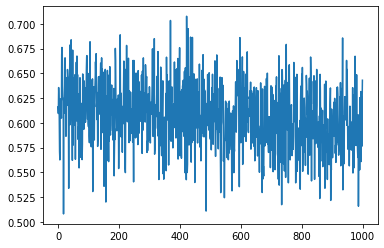

In [0]:
from tensorflow.keras import optimizers
import tensorflow as tf
import matplotlib.pyplot as plt

opt = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9)

for i in range(1):
  train_gen = data_gen(64, data_len)
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, metrics=['accuracy'])
  history = model.fit_generator(generator=train_gen, epochs=1000, verbose=0)
  plt.plot(range(len(history.history['loss'])), history.history['loss'])
  model.save('model' + str(i) + '.h5')
  X, y = train_gen.test_batch()
  model.evaluate(X, y)
plt.show()